## SSAC - Exploration 9 - lightgbm, xgboost, eda : kaggle

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from scipy.stats import spearmanr # spearman corr
from sklearn.model_selection import train_test_split  # 훈련, 테스트 분리
from sklearn.metrics import mean_squared_error  # mse
from xgboost import XGBRegressor  # xgboost
from lightgbm import LGBMRegressor # light gbm
from sklearn.ensemble import RandomForestRegressor  # 랜덤포레스트
from sklearn.model_selection import GridSearchCV   # 그리드 서치
from pingouin import welch_anova

### 1.1 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print(f'train data dim : {train.shape}')
print(f'test data dim : {test.shape}')

train data dim : (15035, 21)
test data dim : (6468, 20)


## 1.2 변수 설명   

ID : 집을 구분하는 번호   
date : 집을 구매한 날짜   
price : 집의 가격(Target variable)   
bedrooms : 침실의 수   
bathrooms : 화장실의 수   
sqft_living : 주거 공간의 평방 피트(면적)   
sqft_lot : 부지의 평방 피트(면적)   
floors : 집의 층 수   
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)   
view : 집이 얼마나 좋아 보이는지의 정도   
condition : 집의 전반적인 상태   
grade : King County grading 시스템 기준으로 매긴 집의 등급   
sqft_above : 지하실을 제외한 평방 피트(면적)   
sqft_basement : 지하실의 평방 피트(면적)   
yr_built : 지어진 년도   
yr_renovated : 집을 재건축한 년도   
zipcode : 우편번호   
lat : 위도   
long : 경도   
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   

In [3]:
display(train.head(2))
display(train.tail(2))

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [4]:
display(test.head(2))
display(test.tail(2))

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [5]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

관련 없는 변수 :   id   

일자 : date   

독립변수   
+ 연속형 변수 : sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15, lat, long       
+ 범주형 변수 : bedrooms, bathrooms, floors, waterfront, view, condition, grade, yr_built, yr_renovated, zipcode    
   
목적변수(target) :  price   

### 1.3 결측치 확인

<AxesSubplot:>

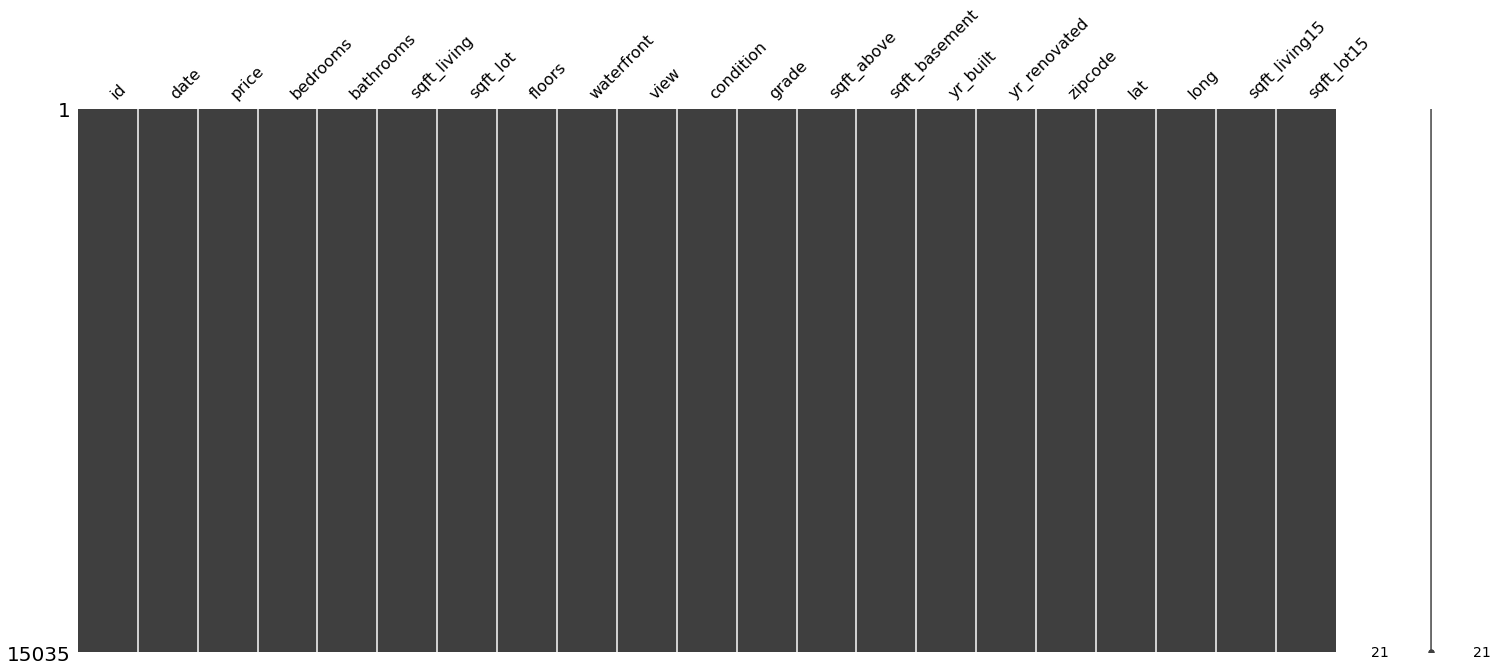

In [6]:
msno.matrix(train)

In [7]:
train.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

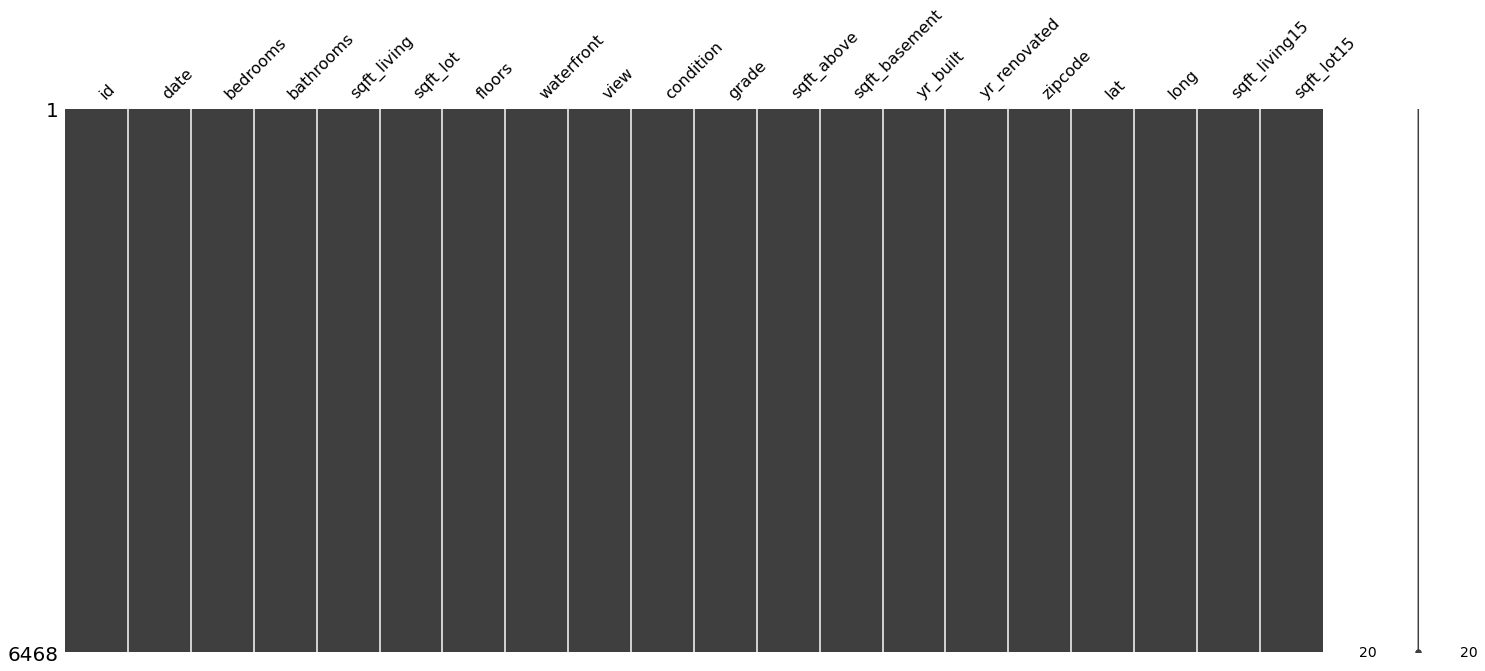

In [8]:
msno.matrix(test)

In [9]:
test.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

+ test, train 모두 결측치 없음

### 1.4 id, date 변수 정리

In [10]:
del train['id']
test_id = test['id']
del test['id']
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(str)

### 1.5 데이터 분포 확인

In [11]:
train.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

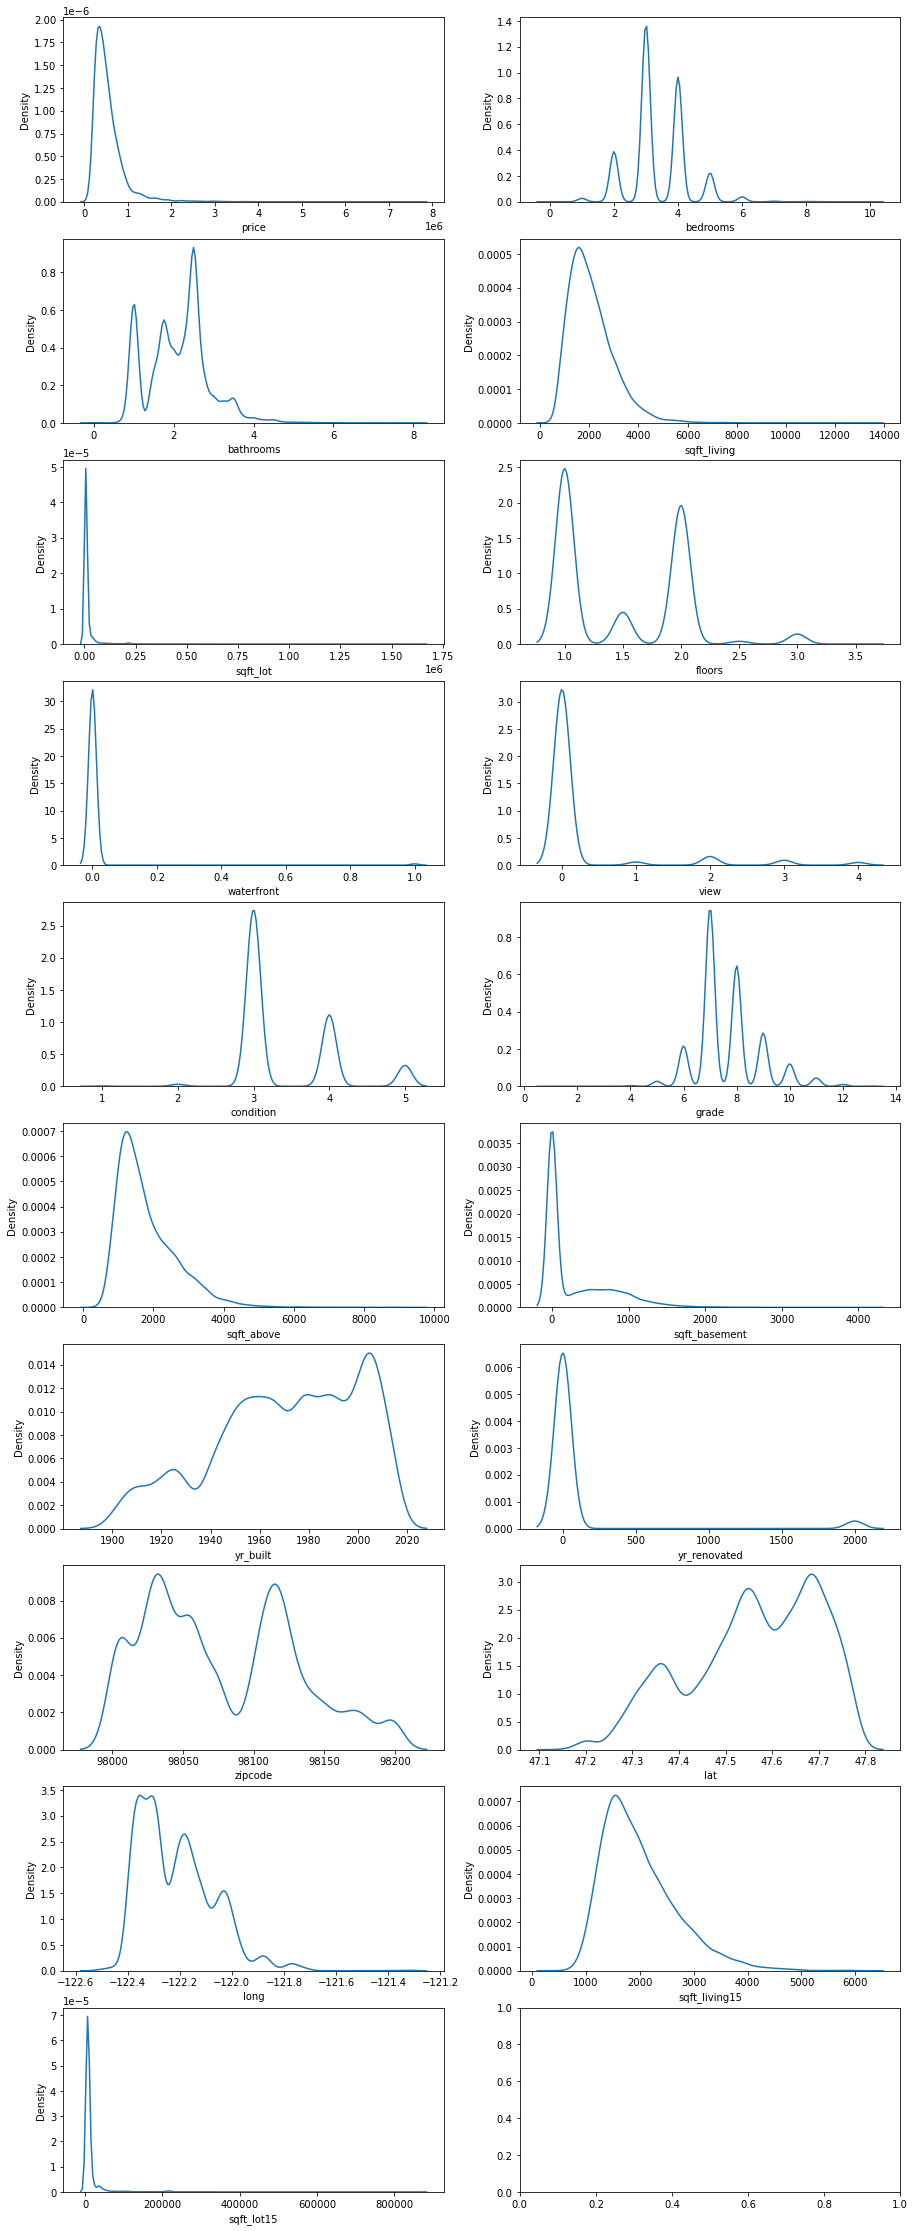

In [12]:
fig, ax = plt.subplots(10, 2, figsize=(15, 40))

count = 0
columns = train.columns[1:]
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        count+=1
        if count == 19 :
            break

연속형 변수 중 price, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보이니 조정해 주기로 한다.

In [13]:
skewed_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skewed_cols:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

train['price'] = np.log1p(train['price'].values)

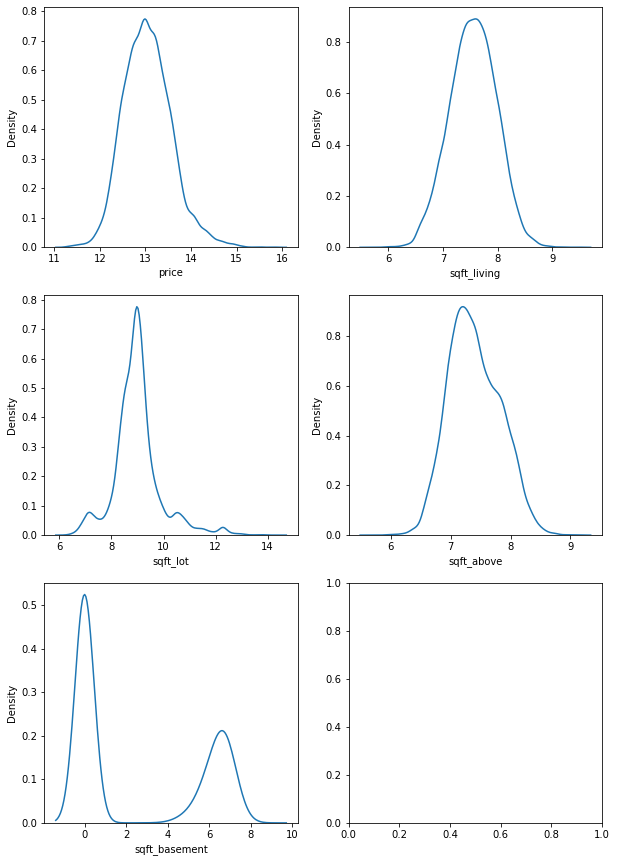

In [14]:
skewed_cols = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skewed_cols[count]], ax=ax[row][col])
        count+=1

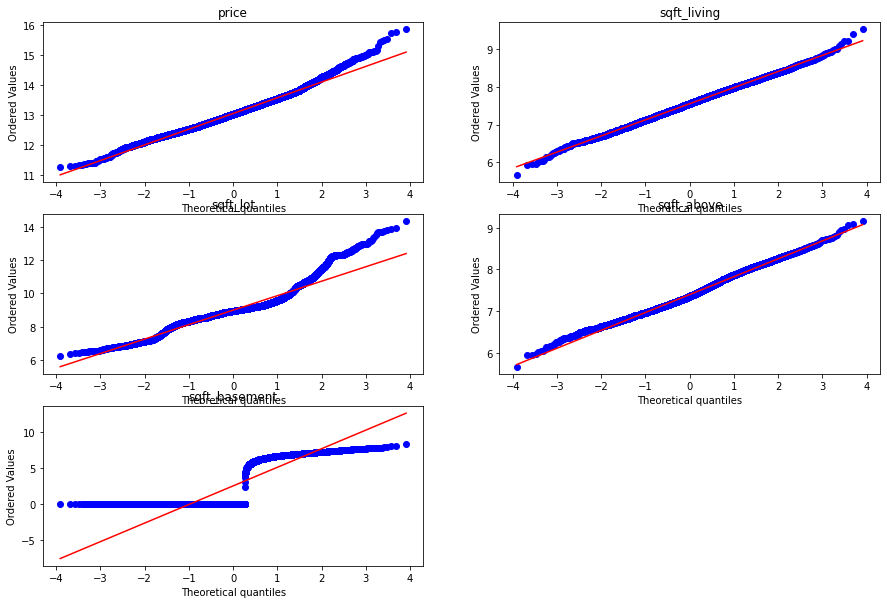

In [15]:
fig = plt.figure(figsize = (15,10))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        fig_num = count+1
        fig.add_subplot(3,2,fig_num)
        stats.probplot(train[skewed_cols[count]], plot=plt)
        plt.title(skewed_cols[count])
       
        count+=1

sqft_basement를 제외하면 대략적으로 덜 치우쳐진 형태로 맞춰진 것 같다. sqft_basement는 지하면적이 전혀 없는 집이 많이 있어서 basement가 있는 집과 없는 집의 가격 차이가 있다면 분류하는 것이 좋을 수도 있겠다.

### 1.6 도시 변수 추가

In [16]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

In [17]:
search.by_zipcode(train.zipcode[0]).values()[2]

'Seattle'

In [18]:
def get_city_with_zipcode(zip_code):
    city = search.by_zipcode(zip_code).values()[2]
    return city

In [19]:
train['city'] = train['zipcode'].apply(get_city_with_zipcode)

In [20]:
print(train.zipcode.nunique())
print(train.city.nunique())

70
24


<AxesSubplot:xlabel='city', ylabel='price'>

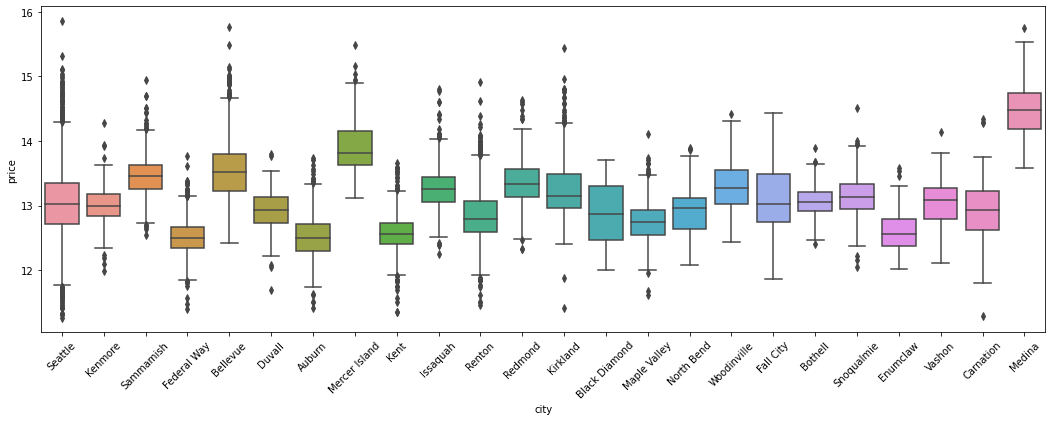

In [21]:
data = pd.concat([train['price'], train['city']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
plt.xticks(rotation=45)
sns.boxplot(x='city', y="price", data=data)

In [24]:
test['city'] = test['zipcode'].apply(get_city_with_zipcode)

In [25]:
train_city = data.city.unique()
test_city = test.city.unique()

In [26]:
train_city.sort() == test_city.sort()

True

train 과 test에 있는 도시 목록이 같으므로 한가지만 사용해서 인코딩을 해도 둘 모두에 적용할 수 있다. 또한 도시 변수를 테스트 셋 예측을 위한 독립변수로 사용하는 것을 고려해볼 수 있다.

In [27]:
cities = data.city.unique()
city_to_index = {city:index for index, city in enumerate(cities)}

In [28]:
def get_encoded_city(city):
    if city in city_to_index:
        return city_to_index[city]

In [29]:
get_encoded_city(data.city[1234])

14

In [32]:
data['city_id'] = data['city'].apply(get_encoded_city)

In [33]:
stats.bartlett(data.city_id, data.price)

BartlettResult(statistic=52237.01328183988, pvalue=0.0)

+ 등분산 가정을 만족하지는 않는다. 이는 상자그림에서도 seattle은 수염도 길고 이상치도 많은 반면 black diamond는 수염도 비교적 짧고 상자 길이는 비교적 길며 이상치도 없는 것을 통해 유추해볼 수 있다.
+ 등분산 가정을 만족하지 않으니 welch_anova 검정을 통해 그룹 간 평균이 동일하다고 할 수 있는지 검토해 본다.

In [34]:
welch_anova(dv='price', between='city_id', data=data) 

,Source,ddof1,ddof2,F,p-unc,np2
0,city_id,23,1323.851543,467.881473,0.0,0.323088


+ 각 도시별 가격의 분포가 정규성을 만족하는지 검토하지는 않았지만 상자그림이나 anova 분석 결과 도시별 가격 평균이 동일한 것처럼 보이지는 않는다. 독립변수로 사용하는 것이 의미가 있을 수 있으므로 변수에 넣어주기로 한다.

In [35]:
train['city_id'] = train['city'].apply(get_encoded_city)
test['city_id'] = test['city'].apply(get_encoded_city)

### 1.7 지하실 유무 변수

In [36]:
train['sqft_basement'][0] == 0

True

In [37]:
def get_basement_status(sqft_base):
    if sqft_base == 0:
        return 0
    else:
        return 1

In [38]:
data = pd.concat([train['price'], train['sqft_basement']], axis=1)
data['basement'] = data['sqft_basement'].apply(get_basement_status)

<AxesSubplot:xlabel='basement', ylabel='price'>

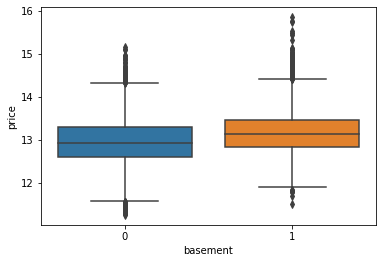

In [39]:
sns.boxplot(x='basement', y="price", data=data)

In [40]:
stats.bartlett(data.basement, data.price)

BartlettResult(statistic=89.95827030473957, pvalue=2.4323659937934123e-21)

In [41]:
welch_anova(dv='price', between='basement', data=data) 

,Source,ddof1,ddof2,F,p-unc,np2
0,basement,1,12343.893458,670.787907,4.567311e-144,0.04315


bartlett 등분산 검정을 통과하지 못하여 welch_anova 검정을 시행한 결과 두 집단 간 평균이 동일하다고 할 수 없는 것으로 보인다.

((array([-3.78840454, -3.56200995, -3.43765985, ...,  3.43765985,
          3.56200995,  3.78840454]),
  array([11.26447693, 11.28979441, 11.30221678, ..., 15.10611994,
         15.10774174, 15.16358397])),
 (0.5096797950973443, 12.960167059921478, 0.9971189666680025))

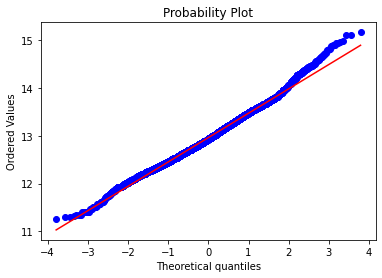

In [42]:
cond = data['basement']==0
wo_base_price = data[cond].price
stats.probplot(wo_base_price, plot=plt)

((array([-3.67778261, -3.44499119, -3.31681456, ...,  3.31681456,
          3.44499119,  3.67778261]),
  array([11.51293546, 11.69442168, 11.79434547, ..., 15.74485584,
         15.7703098 , 15.85673102])),
 (0.517502346566112, 13.184608177137623, 0.987779379449362))

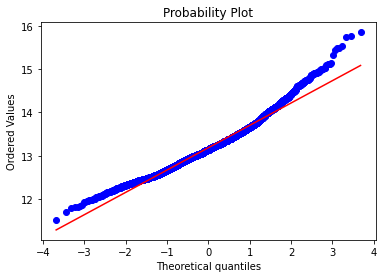

In [43]:
cond = data['basement']!=0
w_base_price = data[cond].price
stats.probplot(w_base_price, plot=plt)

In [44]:
stats.shapiro(w_base_price)

/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9757991433143616, pvalue=1.7470012724406628e-30)

In [45]:
stats.kstest(w_base_price, 'norm', alternative='two-sided')

KstestResult(statistic=1.0, pvalue=0.0)

In [46]:
stats.kstest(wo_base_price, 'norm', alternative='two-sided')

KstestResult(statistic=1.0, pvalue=0.0)

In [47]:
stats.kruskal(w_base_price, wo_base_price)

KruskalResult(statistic=590.5859014954907, pvalue=1.8683885375597163e-130)

In [48]:
stats.mannwhitneyu(w_base_price, wo_base_price)

MannwhitneyuResult(statistic=20621478.5, pvalue=9.342380352887569e-131)

qq-plot과 샤피로, 콜모고로프-스미르노프 검정 결과 지하실이 있는 경우와 없는 경우의 가격 분포가 정규성을 만족하는 것으로 보이지 않아 mann-whitney 검정과 kruskal-walis 검정 시행 결과 유의수준 0.05에서 두 집단의 평균이 동일하다는 귀무가설을 기각한다.

In [49]:
cond = data['basement']!=0
w_base = data[cond]
w_base.corr()

,price,sqft_basement,basement
price,1.000000,0.331292,NaN
sqft_basement,0.331292,1.000000,NaN
basement,NaN,NaN,NaN


+ 지하실이 있는 경우의 가격과 지하실이 없는 경우의 가격의 차이는 있는 것으로 보여 변수로 추가하기로 한다. basement의 넓이와 가격 간의 상관계수가 비교적 작다. 전반적인 상관관계 검토가 필요하다.

In [50]:
train['basement'] = train['sqft_basement'].apply(get_basement_status)
test['basement'] = test['sqft_basement'].apply(get_basement_status)

### 2 상관관계

In [51]:
cols =  'price, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15, lat, long, bedrooms, bathrooms, floors, waterfront, view, condition, grade'.split(', ')

In [52]:
cols

['price',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15',
 'lat',
 'long',
 'bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade']

In [53]:
data = train[cols]

In [54]:
len(cols)

16

In [55]:
data.shape

(15035, 16)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront' 'sqft_lot'
 'long' 'sqft_lot15' 'condition']


<AxesSubplot:>

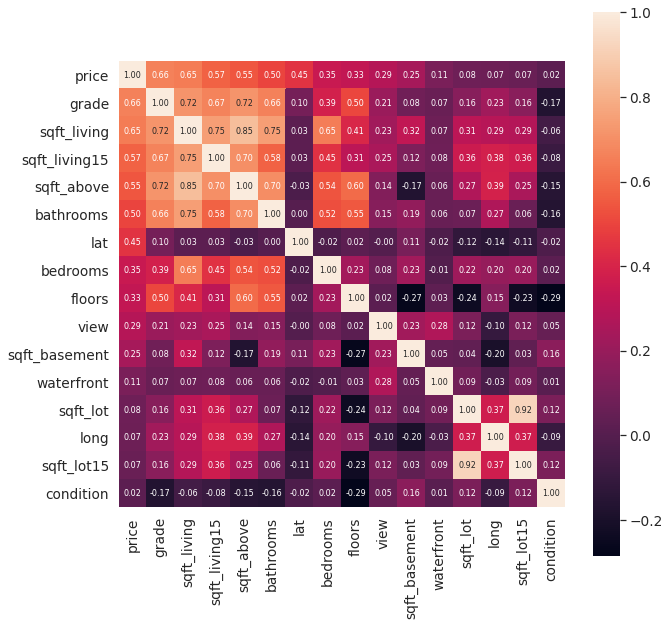

In [56]:
cor_abs = abs(data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=16, columns='price').index
# spearman coefficient matrix ; bedroom 같은 비연속 변수도 있으므로 스피어만 상관계수를 구한다.
cor = np.array(stats.spearmanr(data[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)

+ 가격과 상관관계가 높은 변수로 grade, 주거공간크기, 15년 기준 주거공간 크기, 지하실 제외 면적, 화장실 수 등이 있다. 
+ 목적변수가 구매 당시 가격이며 구매 거래 일시가 15년 이전인 경우 15년 기준 주거공간 크기가 구매 이후 재건축 등으로 변경된 경우 15년 기준 주거공간 크기는 목적변수 예측에 도움이 되지 않을 수도 있다고 생각했었다.
  + 전반적으로 15년 기준 주거공간 크기가 sqft_living에서 변화가 크지 않아 상관관게가 유사하게 나왔을 수도 있겠다고 생각한다.
  + 변수 제거 여부는 좀 생각해봐야겠다.

## 3.1 모델링

In [57]:
y = train['price']
del train['price']
del train['city']
del train['date']
del test['city']
del test['date']

In [58]:
def rmse(y_val, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))

In [59]:
random_state=7         

xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [xgboost, lightgbm, rdforest]

In [60]:
def get_scores(models, train, y):
    
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_val, y_train, y_val = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        df[model_name] = rmse(y_val, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df
get_scores(models, train, y)

,RMSE
RandomForestRegressor,127292.762487
XGBRegressor,117041.793756
LGBMRegressor,108807.505565


### 3.2 그리드 서치

### 3.2.1 lgbm

In [61]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [101]:
model = LGBMRegressor(random_state=random_state)

In [100]:
param_grid = {
    'n_estimators': [50, 100],  # 나무 개수
    'max_depth': [3, 5, 10],    # 나무 최대 깊이
    'learning_rate' : [0.05, 0.1], # 학습률
    'num_leaves' : [8, 31, 1023]
}

In [102]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
34,0.10,10,100,31,-0.027668,0.166338
35,0.10,10,100,1023,-0.028335,0.168330
17,0.05,10,100,1023,-0.028704,0.169424
32,0.10,10,50,1023,-0.028879,0.169939
28,0.10,5,100,31,-0.029101,0.170590
29,0.10,5,100,1023,-0.029309,0.171198
16,0.05,10,100,31,-0.029358,0.171342
31,0.10,10,50,31,-0.029587,0.172010
33,0.10,10,100,8,-0.031576,0.177697
27,0.10,5,100,8,-0.031610,0.177793


learning_rate = 0.1, max_depth = 10, n_estimators = 100, num_leaves = 31

### 3.2.2 xgboost

In [65]:
model = XGBRegressor(random_state=random_state)

In [66]:
param_grid = {
    'n_estimators': [50, 100],  # 나무 개수
    'max_depth': [5, 10],    # 나무 최대 깊이
    'learning_rate' : [0.1] # 학습률
}

In [67]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.1,10,100,-0.027546,0.165969
1,0.1,5,100,-0.029657,0.172213
2,0.1,10,50,-0.034281,0.185152
0,0.1,5,50,-0.038367,0.195875


learning_rate = 0.1, max_depth = 10, n_estimators = 100

### 3.2.3 randomforest

In [68]:
model = RandomForestRegressor(random_state=random_state)

In [69]:
param_grid = { 'n_estimators' : [50, 100], # 나무 개수
           'max_depth' : [3, 5, 10], # 나무 최대 깊이
           'min_samples_leaf' : [1, 8], # 노드 분할 위한 최소 샘플 수
           'min_samples_split' : [2, 8] # 노드가 되기 위해 필요한 최소 샘플 수
            }

In [70]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,max_depth,min_samples_leaf,min_samples_split,n_estimators,score,RMSLE
19,10,1,8,100,-0.034988,0.187050
17,10,1,2,100,-0.035005,0.187097
18,10,1,8,50,-0.035255,0.187762
16,10,1,2,50,-0.035299,0.187880
23,10,8,8,100,-0.036184,0.190222
21,10,8,2,100,-0.036184,0.190222
20,10,8,2,50,-0.036379,0.190734
22,10,8,8,50,-0.036379,0.190734
11,5,1,8,100,-0.058425,0.241713
9,5,1,2,100,-0.058426,0.241715


max_depth =10, min_samples_leaf =1, min_samples_split = 8, n_estimators = 100

### 4. average blending

In [119]:
lightgbm = LGBMRegressor(random_state=random_state, learning_rate = 0.1, max_depth = 10, n_estimators = 100, num_leaves = 31)
xgboost = XGBRegressor(random_state=random_state, learning_rate = 0.1, max_depth = 10, n_estimators = 100)
rforest = RandomForestRegressor(random_state=random_state, max_depth =10, min_samples_leaf = 1, min_samples_split = 8, n_estimators = 100)

In [120]:
models = [xgboost, lightgbm, rforest]
get_scores(models, train, y)

,RMSE
RandomForestRegressor,134815.651219
LGBMRegressor,113236.647911
XGBRegressor,112842.388922


In [121]:
def AveragingBlending(models, x, y, test):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    predictions = np.expm1(predictions)
    return np.average(predictions, weights = [0.5, 0.3, 0.2], axis=1)

In [122]:
models = [{'model':lightgbm, 'name':'LightGBM'}, {'model':xgboost, 'name':'XGBoost'}, {'model':rforest, 'name':'RandomForest'}]
y_pred = AveragingBlending(models, train, y, test)

In [123]:
sub = pd.DataFrame(data={'id':test_id,'price':y_pred})

In [124]:
sub.to_csv('submission.csv', index=False)

private : 115881.47071   
public : 114223.37736   